In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras.metrics import Precision, Recall

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, Dropout, Concatenate, UpSampling2D, BatchNormalization, Activation, Conv2DTranspose, Add, MaxPool2D
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
import gc


In [2]:
# Read and examine metadata
#raw_data = pd.read_csv(r"/content/drive/MyDrive/COVID-19 Lung CT Scan Segmentation/metadata_COLAB.csv")
raw_data = pd.read_csv(r"../COVID-19 Lung CT Scan Segmentation/COVID-19 Lung CT Scan Segmentation/metadata_temp.csv")
raw_data.sample(5)

,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
1,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...
9,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...
8,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...
11,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...
16,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...


In [3]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

In [4]:
# Read sample
sample_ct   = read_nii(raw_data.loc[1,'ct_scan'])
sample_lung = read_nii(raw_data.loc[1,'lung_mask'])
sample_infe = read_nii(raw_data.loc[1,'infection_mask'])
sample_all  = read_nii(raw_data.loc[1,'lung_and_infection_mask'])

# Examine Shape
sample_ct.shape

(512, 512, 200)

Text(0.5, 1.0, 'Lung and Infection Mask')

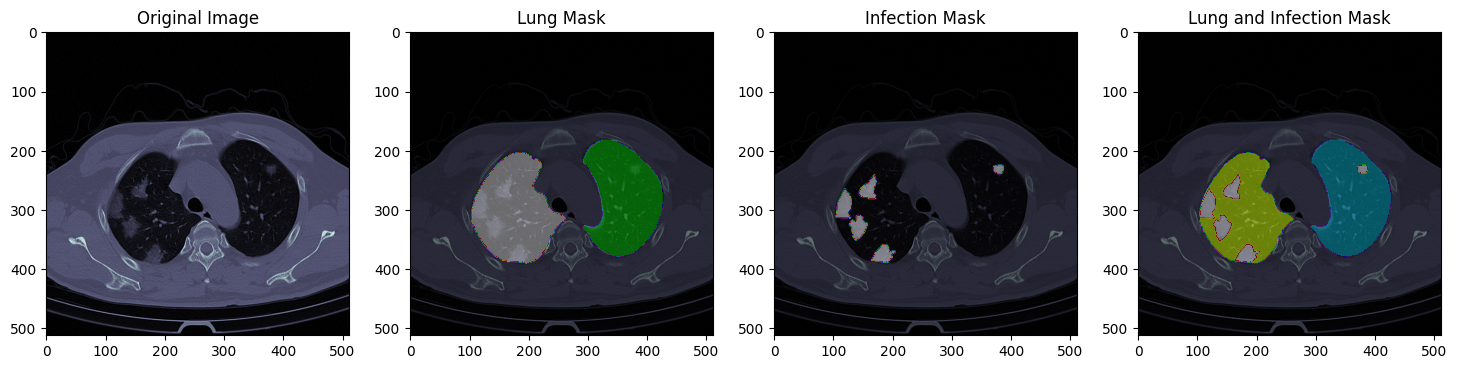

In [5]:
fig = plt.figure(figsize = (18,15))
plt.subplot(1,4,1)
plt.imshow(sample_ct[..., 150], cmap = 'bone')
plt.title('Original Image')

plt.subplot(1,4,2)
plt.imshow(sample_ct[..., 150], cmap = 'bone')
plt.imshow(sample_lung[..., 150],alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Lung Mask')

plt.subplot(1,4,3)
plt.imshow(sample_ct[..., 150], cmap = 'bone')
plt.imshow(sample_infe[..., 150], alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Infection Mask')

plt.subplot(1,4,4)
plt.imshow(sample_ct[..., 150], cmap = 'bone')
plt.imshow(sample_all[..., 150], alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Lung and Infection Mask')

In [6]:
IMG_SIZE = 128
IMG_HEIGHT = IMG_SIZE
IMG_WIDTH = IMG_SIZE
IMG_CHANNELS = 1

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

def get_data():
    lungs_data = []
    infections_data  = []

    for row in range(len(raw_data)):
        lungs_image = read_nii(raw_data['ct_scan'][row])
        infection_image = read_nii(raw_data['infection_mask'][row])

        for slice_no in range(lungs_image.shape[2]):
            lung_slice = cv2.resize(lungs_image[..., slice_no], dsize=(IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
            infection_slice = cv2.resize(infection_image[..., slice_no], dsize=(IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')

            lung_slice_temp = lung_slice.reshape(-1, 2)
            lung_slice_temp = scaler.fit_transform(lung_slice_temp)
            lung_slice = lung_slice_temp.reshape(lung_slice.shape)
            lungs_data.append(lung_slice[..., np.newaxis])

            infections_data.append(infection_slice[..., np.newaxis])
    return lungs_data, infections_data

In [8]:
data = get_data()
lungs = np.array(data[0])
infections = np.array(data[1])

Text(0.5, 1.0, 'Transformed Infection Mask')

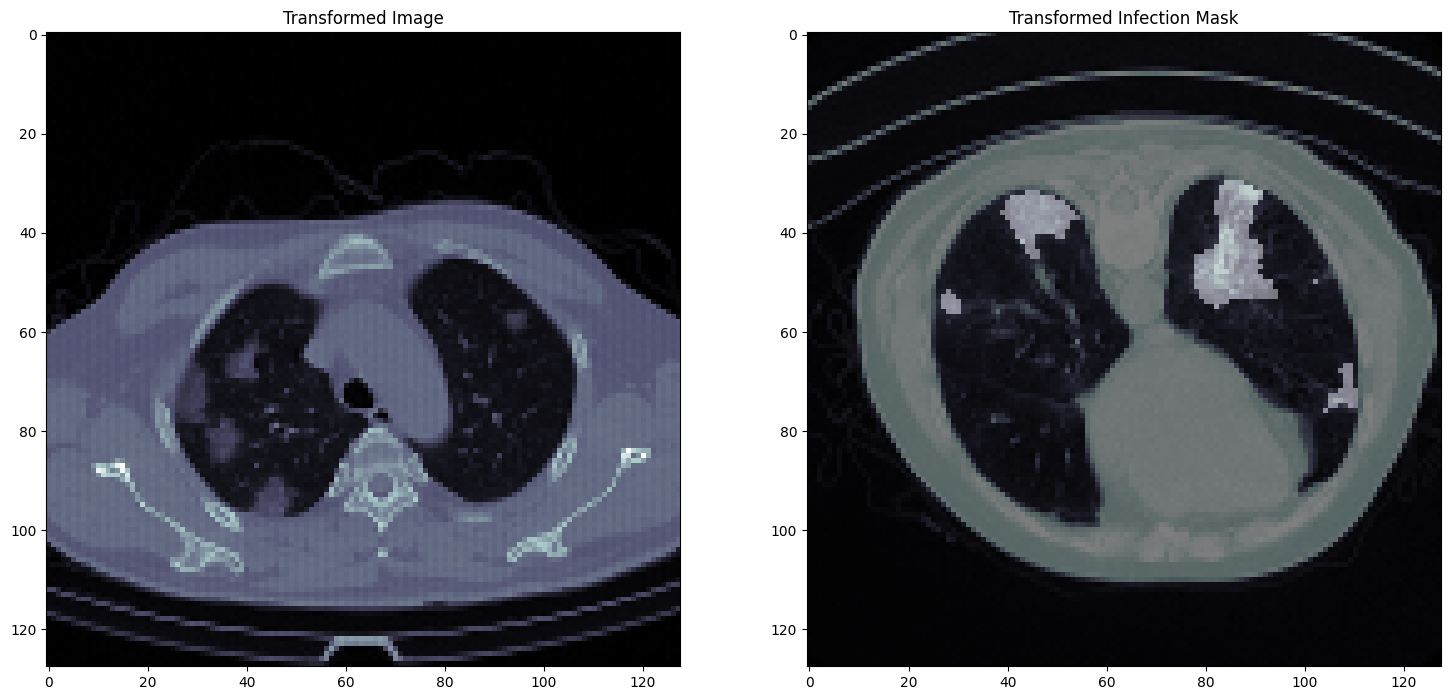

In [19]:
fig = plt.figure(figsize = (18,15))
plt.subplot(1,2,1)
plt.imshow(lungs[451], cmap = 'bone')
plt.title('Transformed Image')

plt.subplot(1,2,2)
plt.imshow(lungs[451], cmap = 'bone')
plt.imshow(infections[451],alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Transformed Infection Mask')

In [10]:
# Split the data into train and test sets
lung_train, lung_test, infect_train, infect_test = train_test_split(lungs, infections, test_size=0.1, shuffle=True)


In [11]:
lung_train.shape, lung_test.shape, infect_train.shape, infect_test.shape

((3168, 128, 128, 1),
 (352, 128, 128, 1),
 (3168, 128, 128, 1),
 (352, 128, 128, 1))

In [13]:
"""Modified"""
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomCrop, GaussianNoise

In [14]:
def conv_block(x, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(x, num_filters):
    x = conv_block(x, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def attention_gate(g, s, num_filters):
    Wg = Conv2D(num_filters, 1, padding="same")(g)
    Wg = BatchNormalization()(Wg)

    Ws = Conv2D(num_filters, 1, padding="same")(s)
    Ws = BatchNormalization()(Ws)

    out = Activation("relu")(Wg + Ws)
    out = Conv2D(num_filters, 1, padding="same")(out)
    out = Activation("sigmoid")(out)

    return out * s

def decoder_block(x, s, num_filters):
    x = UpSampling2D(interpolation="bilinear")(x)
    s = attention_gate(x, s, num_filters)
    x = Concatenate()([x, s])
    x = conv_block(x, num_filters)
    return x

def attention_unet(input_shape):
    """ Inputs """
    inputs = Input(input_shape)

    aug = RandomRotation(10)(inputs)
    aug = RandomZoom(0.1)(aug)
    aug = RandomContrast(0.1)(aug)
    aug = GaussianNoise(10)(aug)
    inputs = aug  

    """ Encoder """
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)

    b1 = conv_block(p3, 512)

    """ Decoder """
    d1 = decoder_block(b1, s3, 256)
    d2 = decoder_block(d1, s2, 128)
    d3 = decoder_block(d2, s1, 64)

    """ Outputs """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d3)

    """ Model """
    model = Model(inputs, outputs, name="Attention-UNET")
    return model


In [15]:
if __name__ == "__main__":
    input_shape = (128, 128, 1)
    model = attention_unet(input_shape)
    model.summary()

Model: "Attention-UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[1][0]']                 
 alization)                     )                                                    

In [16]:
import tensorflow.keras.backend as K

def jaccard_loss(y_true, y_pred, smooth=1e-7):
    y_true = K.cast(y_true, dtype='float32')  # Cast y_true to float32
    intersection = K.sum(y_true * y_pred, axis=(1, 2, 3))
    union = K.sum(y_true, axis=(1, 2, 3)) + K.sum(y_pred, axis=(1, 2, 3)) - intersection
    jaccard = (intersection + smooth) / (union + smooth)
    return 1 - jaccard

In [17]:
from keras import backend as K
K.clear_session()
metrics = ["accuracy",
           tf.keras.metrics.AUC(),
           tf.keras.metrics.SensitivityAtSpecificity(0.5),
           tf.keras.metrics.SpecificityAtSensitivity(0.5),
           tf.keras.metrics.MeanIoU(num_classes=2)]  # Use MeanIoU as the Jaccard Index metric
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=metrics)  # Use custom Jaccard loss

gc.collect()

92

In [18]:
model.summary()

Model: "Attention-UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[1][0]']                 
 alization)                     )                                                    

In [19]:
# Define callbacks
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-Unet.h5', verbose=1, save_best_only=True, save_weights_only=True),
]


In [20]:
results = model.fit(lung_train, infect_train, batch_size=8, epochs=50, callbacks=callbacks, validation_data=(lung_test, infect_test), use_multiprocessing=True)


Epoch 1/50
396/396 [==============================] - ETA: 0s - loss: 0.0591 - accuracy: 0.9894 - auc: 0.8863 - sensitivity_at_specificity: 0.9522 - specificity_at_sensitivity: 0.9465 - mean_io_u: 0.4967
Epoch 1: val_loss improved from inf to 0.04241, saving model to model-Unet.h5
396/396 [==============================] - 113s 257ms/step - loss: 0.0591 - accuracy: 0.9894 - auc: 0.8863 - sensitivity_at_specificity: 0.9522 - specificity_at_sensitivity: 0.9465 - mean_io_u: 0.4967 - val_loss: 0.0424 - val_accuracy: 0.9925 - val_auc: 0.5084 - val_sensitivity_at_specificity: 0.0616 - val_specificity_at_sensitivity: 0.0473 - val_mean_io_u: 0.4965 - lr: 0.0010
Epoch 2/50
396/396 [==============================] - ETA: 0s - loss: 0.0158 - accuracy: 0.9954 - auc: 0.9853 - sensitivity_at_specificity: 0.9871 - specificity_at_sensitivity: 0.9987 - mean_io_u: 0.4967
Epoch 2: val_loss improved from 0.04241 to 0.02685, saving model to model-Unet.h5
396/396 [==============================] - 103s 260m

In [21]:
df_result = pd.DataFrame(results.history)
df_result.sort_values('val_loss', ascending=True, inplace = True)
df_result

,loss,accuracy,auc,sensitivity_at_specificity,specificity_at_sensitivity,mean_io_u,val_loss,val_accuracy,val_auc,val_sensitivity_at_specificity,val_specificity_at_sensitivity,val_mean_io_u,lr
40,0.003152,0.998669,0.999096,0.998654,0.999991,0.496723,0.004477,0.998173,0.997214,0.995241,0.999959,0.49652,0.00001
32,0.003231,0.998634,0.999087,0.998660,0.999992,0.496723,0.004485,0.998163,0.997295,0.995416,0.999959,0.49652,0.00001
30,0.003274,0.998620,0.999069,0.998636,0.999988,0.496723,0.004494,0.998151,0.997328,0.995491,0.999959,0.49652,0.00001
44,0.003122,0.998680,0.999115,0.998683,0.999992,0.496723,0.004495,0.998171,0.997078,0.994967,0.999957,0.49652,0.00001
35,0.003190,0.998654,0.999120,0.998713,0.999992,0.496723,0.004496,0.998162,0.997197,0.995216,0.999955,0.49652,0.00001
34,0.003194,0.998649,0.999103,0.998680,0.999991,0.496723,0.004497,0.998165,0.997123,0.995067,0.999955,0.49652,0.00001
31,0.003243,0.998635,0.999080,0.998648,0.999989,0.496723,0.004499,0.998153,0.997293,0.995416,0.999957,0.49652,0.00001
49,0.003081,0.998696,0.999146,0.998733,0.999992,0.496723,0.004501,0.998180,0.996782,0.994369,0.999958,0.49652,0.00001
33,0.003215,0.998640,0.999126,0.998733,0.999991,0.496723,0.004504,0.998162,0.997281,0.995391,0.999956,0.49652,0.00001
47,0.003090,0.998690,0.999145,0.998733,0.999991,0.496723,0.004508,0.998172,0.996632,0.994070,0.999960,0.49652,0.00001


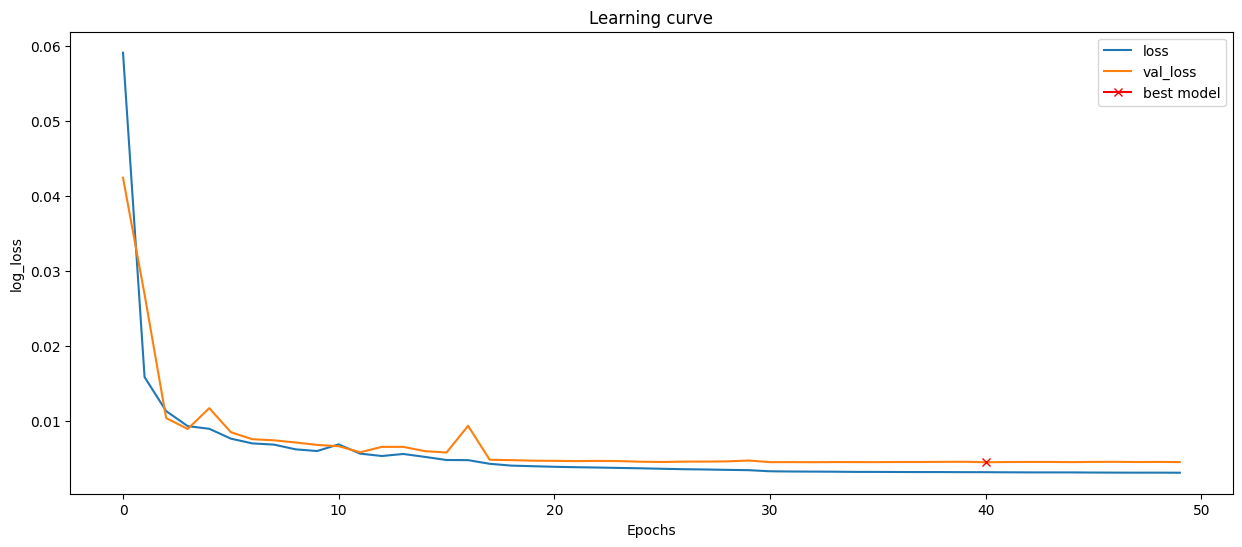

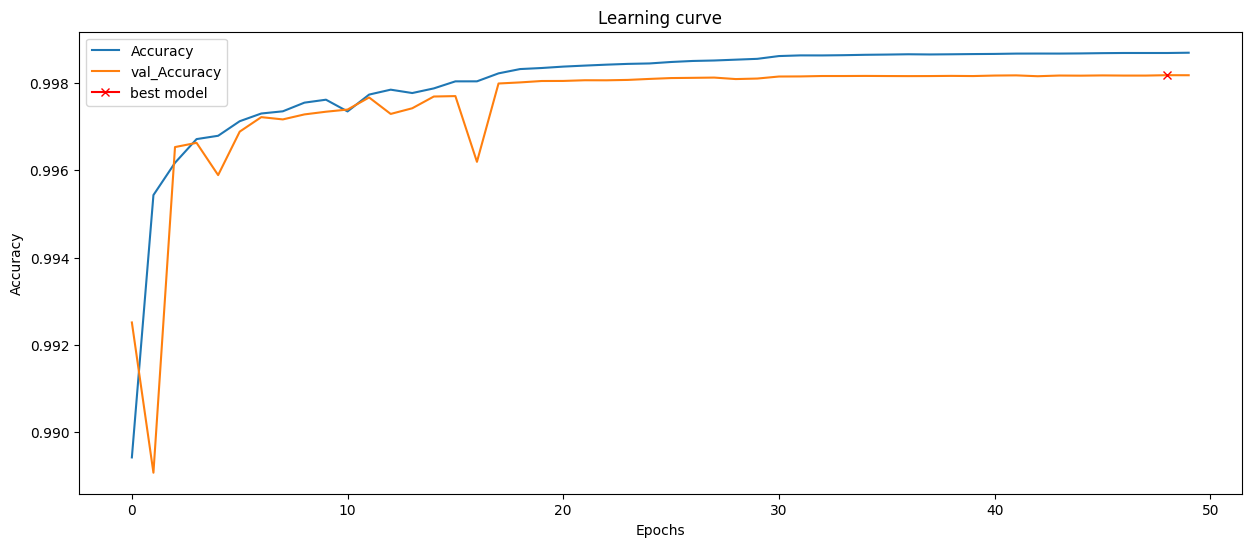

In [22]:
plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["accuracy"], label="Accuracy")
plt.plot(results.history["val_accuracy"], label="val_Accuracy")
plt.plot(np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();


In [24]:
model.save("UNet_Attention_JB.h5")

In [13]:
model = tf.keras.models.load_model("Attention_Unet.h5")

In [14]:
device = "CPU:0"

In [15]:
with tf.device(device):
    # Calculate metrics
    predicted = model.predict(lung_test)

    # Flatten the predicted and true masks
    predicted_flat = np.round(np.array(predicted).flatten())
    infect_test_flat = np.array(infect_test).flatten()

In [16]:
with tf.device(device):
    # Calculate metrics for training data
    train_predicted = model.predict(lung_train)

    # Calculate metrics for testing data
    test_predicted = model.predict(lung_test)

In [18]:
train_predicted.shape, infect_train.shape

((3168, 128, 128, 1), (3168, 128, 128, 1))

In [35]:
with tf.device(device):
    # Flatten the predicted and true masks
    train_predicted_flat = np.round(np.array(train_predicted).flatten())
    infect_train_flat = np.array(infect_train).flatten()

    # Calculate precision and recall for training data
    train_precision = Precision()
    train_recall = Recall()
    train_precision.update_state(infect_train_flat, train_predicted_flat)
    train_recall.update_state(infect_train_flat, train_predicted_flat)

    # Calculate F1 score for training data
    train_f1_score = 2 * (train_precision.result() * train_recall.result()) / (train_precision.result() + train_recall.result())

    # Calculate accuracy for training data
    train_accuracy = np.mean(train_predicted_flat == infect_train_flat)


    # Flatten the predicted and true masks for testing data
    test_predicted_flat = np.round(np.array(test_predicted).flatten())
    infect_test_flat = np.array(infect_test).flatten()

    # Calculate precision and recall for testing data
    test_precision = Precision()
    test_recall = Recall()
    test_precision.update_state(infect_test_flat, test_predicted_flat)
    test_recall.update_state(infect_test_flat, test_predicted_flat)

    # Calculate F1 score for testing data
    test_f1_score = 2 * (test_precision.result() * test_recall.result()) / (test_precision.result() + test_recall.result())

    # Calculate accuracy for testing data
    test_accuracy = np.mean(test_predicted_flat == infect_test_flat)

    # Calculate parameters
    total_parameters = np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])

    # Calculate FLOPs
    # flops = get_flops(model, batch_size=1)  # Assuming batch_size = 1

    # Print the metrics for training data
    print("Training Metrics:")
    print("Precision: ", train_precision.result().numpy())
    print("Recall: ", train_recall.result().numpy())
    print("F1 Score: ", train_f1_score.numpy())
    print("Accuracy: ", train_accuracy)

    # Print the metrics for testing data
    print("\nTesting Metrics:")
    print("Precision: ", test_precision.result().numpy())
    print("Recall: ", test_recall.result().numpy())
    print("F1 Score: ", test_f1_score.numpy())
    print("Accuracy: ", test_accuracy)

    # Print the other metrics
    print("\nTotal Parameters: ", total_parameters)
    # print("FLOPs: ", flops)


Training Metrics:
Precision:  0.9089704
Recall:  0.8950342
F1 Score:  0.90194845
Accuracy:  0.9987245039506392

Testing Metrics:
Precision:  0.88055867
Recall:  0.85445213
F1 Score:  0.8673089
Accuracy:  0.9981803894042969

Total Parameters:  8134593


In [36]:
with tf.device(device):
    # Calculate Jaccard Index (MeanIoU) for training data
    train_iou = tf.keras.metrics.MeanIoU(num_classes=2)
    train_iou.update_state(infect_train_flat, train_predicted_flat)
    train_mean_iou = train_iou.result().numpy()

    # Calculate Jaccard Index (MeanIoU) for testing data
    test_iou = tf.keras.metrics.MeanIoU(num_classes=2)
    test_iou.update_state(infect_test_flat, test_predicted_flat)
    test_mean_iou = test_iou.result().numpy()

    # Print the Jaccard Index (MeanIoU) for training and testing data
    print("Training Jaccard Index (MeanIoU): ", train_mean_iou)
    print("Testing Jaccard Index (MeanIoU): ", test_mean_iou)


Training Jaccard Index (MeanIoU):  0.9087388
Testing Jaccard Index (MeanIoU):  0.8819381


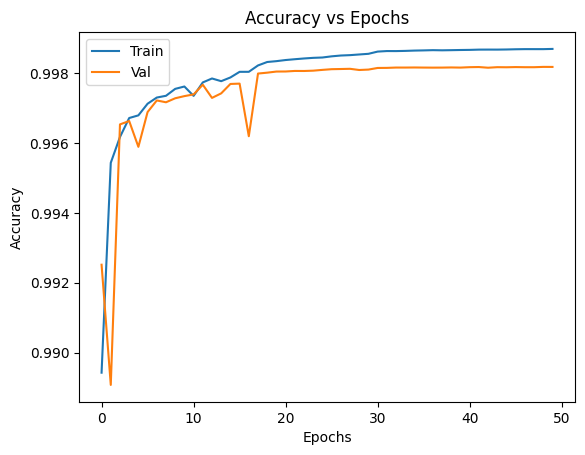

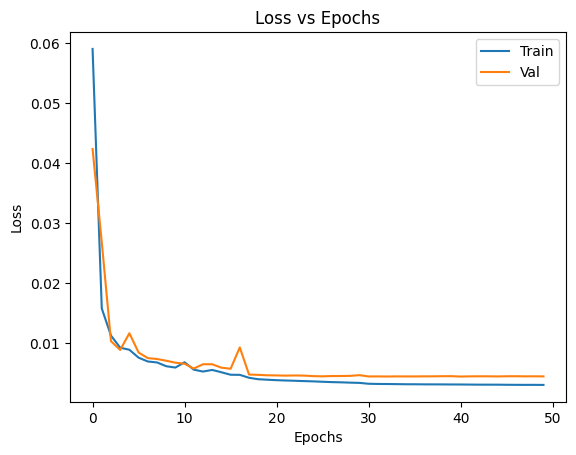

In [37]:
# Plot accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [38]:
with tf.device(device):
    # Make predictions
    predicted = model.predict(lung_test)

Text(0.5, 1.0, 'Predicted infection mask')

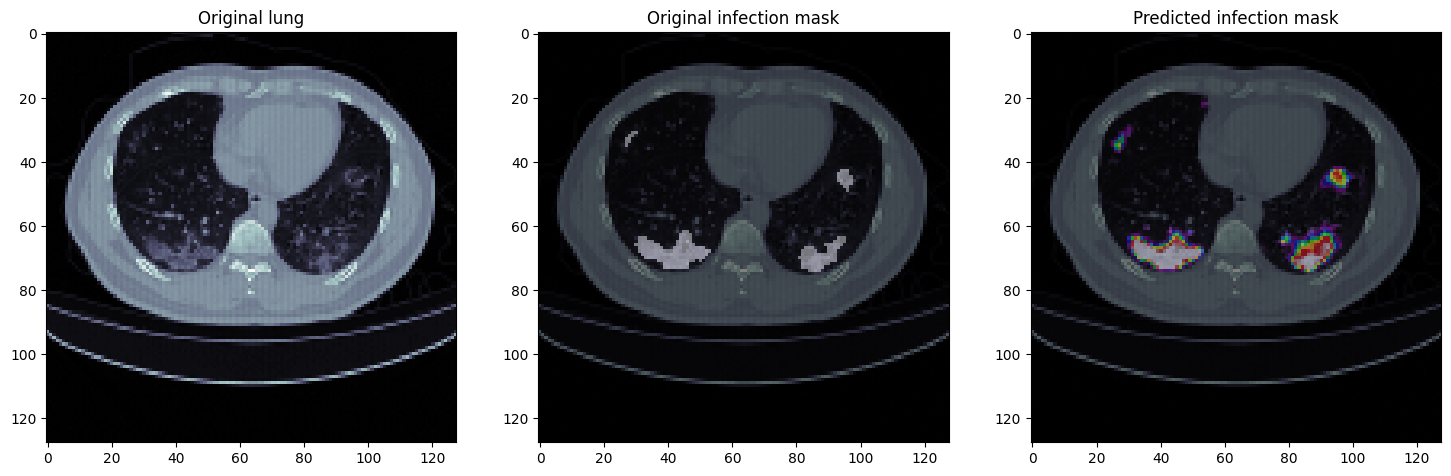

In [50]:
# Make predictions and visualize
img_num = 9
#predicted = model.predict(lung_test)

# Visualize results
fig = plt.figure(figsize=(18, 15))
plt.subplot(1, 3, 1)
plt.imshow(lung_test[img_num], cmap='bone')
plt.title('Original lung')

plt.subplot(1, 3, 2)
plt.imshow(lung_test[img_num], cmap='bone')
plt.imshow(infect_test[img_num][..., 0], alpha=0.5, cmap="nipy_spectral")
plt.title('Original infection mask')

plt.subplot(1, 3, 3)
plt.imshow(lung_test[img_num], cmap='bone')
plt.imshow(predicted[img_num], alpha=0.5, cmap="nipy_spectral")
plt.title('Predicted infection mask')

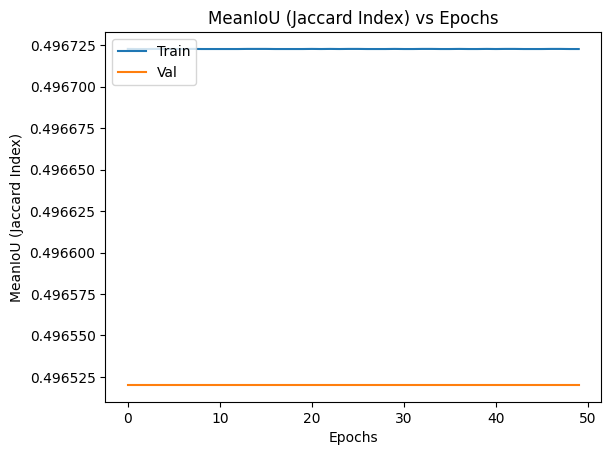

In [51]:
# Plot Jaccard Index (MeanIoU)
plt.plot(results.history['mean_io_u'])
plt.plot(results.history['val_mean_io_u'])
plt.title('MeanIoU (Jaccard Index) vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('MeanIoU (Jaccard Index)')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [52]:
model.save_weights("UNet_Attention.h5")